# Georgian Spellchecker - Data Collection and Training

Character-level Seq2Seq model for Georgian spelling correction

## Overview
Complete pipeline for building a Georgian spellchecker with:
1. Data Collection (Wikipedia)
2. Synthetic Error Generation
3. Model Architecture (Encoder-Decoder + Attention)
4. Training Loop
5. Model Evaluation and Saving

In [1]:
import re, json, bz2, random, time
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import Counter
from typing import List, Tuple, Set

import requests
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt

from model import Seq2SeqSpellchecker, CharacterVocabulary, count_parameters

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

Path('data').mkdir(exist_ok=True)
Path('checkpoints').mkdir(exist_ok=True)

torch.manual_seed(42)
random.seed(42)

PyTorch: 2.9.0+cu126
CUDA: True


## 1. Data Collection

We collect Georgian words from Wikipedia dump.

In [2]:
from wikipedia_collector import GeorgianWikipediaProcessor

# use GeorgianWikipediaProcessor class from wikipedia_collector.py
processor = GeorgianWikipediaProcessor(output_dir='data')
processor.process_dump(max_articles=5000)

Georgian Wikipedia Processing Pipeline
URL: https://dumps.wikimedia.org/kawiki/latest/kawiki-latest-pages-articles.xml.bz2


100%|██████████| 227M/227M [00:50<00:00, 4.50MB/s]


Download complete: data/kawiki-latest-pages-articles.xml.bz2
extracting text from wikipedia dump...
  Processed 1000 articles, found 0 unique words...
  Processed 2000 articles, found 0 unique words...
  Processed 3000 articles, found 0 unique words...
  Processed 4000 articles, found 0 unique words...
  Processed 5000 articles, found 0 unique words...
Extracted text from 5000 articles

Extracting Georgian words from articles...


  8%|▊         | 411/5000 [00:00<00:01, 4011.09it/s]

  Progress: 24285 unique words found...


 24%|██▍       | 1191/5000 [00:00<00:03, 1148.14it/s]

  Progress: 62168 unique words found...


 31%|███▏      | 1574/5000 [00:01<00:02, 1319.14it/s]

  Progress: 76969 unique words found...


 44%|████▍     | 2193/5000 [00:01<00:02, 1203.19it/s]

  Progress: 99706 unique words found...


 56%|█████▋    | 2814/5000 [00:02<00:01, 1323.73it/s]

  Progress: 115691 unique words found...


 65%|██████▌   | 3250/5000 [00:02<00:01, 1303.64it/s]

  Progress: 125273 unique words found...


 73%|███████▎  | 3628/5000 [00:03<00:01, 1104.28it/s]

  Progress: 138041 unique words found...


 88%|████████▊ | 4389/5000 [00:03<00:00, 1908.04it/s]

  Progress: 144968 unique words found...


100%|██████████| 5000/5000 [00:03<00:00, 1403.63it/s]

  Progress: 152234 unique words found...
  Progress: 157080 unique words found...

Extraction complete: 157080 unique words


DATASET STATISTICS
Total unique words:      157,080
Character vocabulary:    33
Shortest word length:    2
Longest word length:     20
Average word length:     8.9

Most common characters:  აიესროლმნდბვუთტგკშხქ
Sample words (first 30):
 1. აა
 2. ააბენრაას
 3. ააგდო
 4. ააგეს
 5. ააგო
 6. ააგორა
 7. ააგრეთვე
 8. აადგილი
 9. აადვილებდა
10. აადვილებს
11. აავადებდნენ
12. აავადებს
13. აავი
14. აავსო
15. ააიმას
16. ააიპ
17. ააკანალის
18. ააკერებდნენ
19. ააკლებინა
20. აალაპარაკა
21. აალებადია
22. აალებული
23. აალი
24. აალსტი
25. აალტო
26. აალტოზე
27. აალტომ
28. აალტონენი
29. აალტოს
30. აალტოში

Saved word list: data/georgian_words.txt (157080 words)
Saved vocabulary: data/char_vocab.json (33 characters)
Saved metadata: data/metadata.json


## 2. Synthetic Error Generation

Generate realistic spelling errors:
- Substitution (40%): keyboard-adjacent keys
- Deletion (25%)
- Insertion (15%)
- Swap (15%)
- Repetition (5%)

In [3]:
from error_generator import GeorgianErrorGenerator

# use the GeorgianErrorGenerator class from error_generator.py
with open('data/georgian_words.txt', 'r', encoding='utf-8') as f:
    words = [line.strip() for line in f if line.strip()]

generator = GeorgianErrorGenerator()
dataset = generator.generate_dataset(words, samples_per_word=3, seed=42)

generator.show_examples(dataset, n=30)
generator.analyze_errors(dataset)
generator.save_dataset(dataset, 'data/training_pairs.txt')

Generating training pairs...
Words: 157080
Samples per word: 3
Expected dataset size: ~471,240
  Processed 10,000 words, generated 30,000 pairs...
  Processed 20,000 words, generated 60,000 pairs...
  Processed 30,000 words, generated 90,000 pairs...
  Processed 40,000 words, generated 120,000 pairs...
  Processed 50,000 words, generated 150,000 pairs...
  Processed 60,000 words, generated 180,000 pairs...
  Processed 70,000 words, generated 210,000 pairs...
  Processed 80,000 words, generated 240,000 pairs...
  Processed 90,000 words, generated 270,000 pairs...
  Processed 100,000 words, generated 300,000 pairs...
  Processed 110,000 words, generated 330,000 pairs...
  Processed 120,000 words, generated 360,000 pairs...
  Processed 130,000 words, generated 390,000 pairs...
  Processed 140,000 words, generated 420,000 pairs...
  Processed 150,000 words, generated 450,000 pairs...

 Generated 471,240 training pairs
SAMPLE TRAINING PAIRS
Input (Corrupted)              → Target (Correct) 

## 3. Model Architecture

**Encoder-Decoder with Attention**:
- Encoder: Bidirectional LSTM (reads corrupted word)
- Attention: Focuses on relevant input positions
- Decoder: LSTM (generates corrected word)

Architecture imported from `model.py`

In [ ]:
vocab = CharacterVocabulary()
print(f"Vocabulary size: {len(vocab)}")

model = Seq2SeqSpellchecker(
    vocab_size=len(vocab),
    embedding_dim=128,      
    encoder_dim=256,       
    decoder_dim=256,        
    attention_dim=128,      
    num_layers=2,          
    dropout=0.3
)

print(f"Parameters: {count_parameters(model):,}")

Vocabulary size: 37
Parameters: 25,158,693


## 4. Training Pipeline

Configuration:
- Batch size: 128
- Learning rate: 0.001
- Epochs: 20 (with early stopping)
- Train/Val split: 90/10

In [5]:
class SpellingDataset(Dataset):
    def __init__(self, data_path, vocab):
        self.vocab = vocab
        self.pairs = []

        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    inp, tgt = line.strip().split('\t')
                    self.pairs.append((inp, tgt))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        inp, tgt = self.pairs[idx]
        src = torch.tensor(self.vocab.encode(inp))
        trg = torch.tensor([self.vocab.sos_idx] +
                          self.vocab.encode(tgt) +
                          [self.vocab.eos_idx])
        return src, trg

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_lengths = torch.tensor([len(s) for s in src_batch])
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=0)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=0)
    return src_padded, src_lengths, trg_padded

# load data
full_dataset = SpellingDataset('data/training_pairs.txt', vocab)

# split
val_size = int(0.1 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=128,
                         shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128,
                       shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_dataset):,}, Val: {len(val_dataset):,}")

Train: 424,116, Val: 47,124


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)


# create bigger model
model_v2 = Seq2SeqSpellchecker(
    vocab_size=len(vocab),
    embedding_dim=256,      # Was: 128
    encoder_dim=512,        # Was: 256
    decoder_dim=512,        # Was: 256
    attention_dim=256,      # Was: 128
    num_layers=3,           # Was: 2
    dropout=0.3
).to(device)


# new optimizer
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.001)
scheduler_v2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_v2, mode='min', factor=0.5, patience=3
)

# define the loss function (criterion)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# training history
train_losses_v2 = []
val_losses_v2 = []
best_val_loss_v2 = float('inf')

# training loop
for epoch in range(1, 31):
    print(f"\nEpoch {epoch}/30")

    # train
    model_v2.train()
    epoch_loss = 0
    batch_count = 0

    for src, src_len, trg in train_loader:
        src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)

        optimizer_v2.zero_grad()
        output = model_v2(src, src_len, trg, teacher_forcing_ratio=0.5)

        loss = criterion(output[:, 1:].contiguous().view(-1, len(vocab)),
                        trg[:, 1:].contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_v2.parameters(), 1.0)
        optimizer_v2.step()

        epoch_loss += loss.item()
        batch_count += 1

        if batch_count % 500 == 0:
            print(f"  Batch {batch_count}/{len(train_loader)}, Loss: {loss.item():.4f}")

    train_loss = epoch_loss / len(train_loader)

    # validate
    model_v2.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for src, src_len, trg in val_loader:
            src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)
            output = model_v2(src, src_len, trg, teacher_forcing_ratio=0)
            loss = criterion(output[:, 1:].contiguous().view(-1, len(vocab)),
                           trg[:, 1:].contiguous().view(-1))
            val_epoch_loss += loss.item()

    val_loss = val_epoch_loss / len(val_loader)

    train_losses_v2.append(train_loss)
    val_losses_v2.append(val_loss)

    scheduler_v2.step(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {optimizer_v2.param_groups[0]['lr']:.6f}")

    # save best model
    if val_loss < best_val_loss_v2:
        best_val_loss_v2 = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_v2.state_dict(),
            'optimizer_state_dict': optimizer_v2.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'checkpoints/best_model.pt')
        print("best model saved!")

    # test samples every 5 epochs
    if epoch % 5 == 0:
        print("\nSample Predictions:")
        src, src_len, trg = next(iter(val_loader))
        src, src_len = src.to(device), src_len.to(device)

        with torch.no_grad():
            preds = model_v2.predict(src[:10], src_len[:10], 30, vocab.sos_idx, vocab.eos_idx)

        for i in range(10):
            inp = vocab.decode(src[i].cpu().tolist())
            tgt = vocab.decode(trg[i].cpu().tolist())
            pred = vocab.decode(preds[i].cpu().tolist())
            correct = "✓" if pred == tgt else "✗"
            print(f"  {correct} {inp:20s} \u2192 {pred:20s} (Target: {tgt})")

    # early stopping if no improvement for 8 epochs
    if epoch > 10 and val_loss > min(val_losses_v2[-8:]):
        print(f"\nEarly stopping - no improvement for 8 epochs")
        break



print(f"\nModel")
print(f"  Parameters: {count_parameters(model_v2):,}")
print(f"  Best Val Loss: {best_val_loss_v2:.4f}")


Epoch 1/30
  Batch 500/3314, Loss: 0.7270
  Batch 1000/3314, Loss: 0.7078
  Batch 1500/3314, Loss: 0.6113
  Batch 2000/3314, Loss: 0.5910
  Batch 2500/3314, Loss: 0.5693
  Batch 3000/3314, Loss: 0.5949
Train Loss: 0.7177, Val Loss: 0.9481
Learning Rate: 0.001000
best model saved!

Epoch 2/30
  Batch 500/3314, Loss: 0.4928
  Batch 1000/3314, Loss: 0.5911
  Batch 1500/3314, Loss: 0.4825
  Batch 2000/3314, Loss: 0.5047
  Batch 2500/3314, Loss: 0.5036
  Batch 3000/3314, Loss: 0.4916
Train Loss: 0.5417, Val Loss: 0.8984
Learning Rate: 0.001000
best model saved!

Epoch 3/30
  Batch 500/3314, Loss: 0.5699
  Batch 1000/3314, Loss: 0.5058
  Batch 1500/3314, Loss: 0.5095
  Batch 2000/3314, Loss: 0.4006
  Batch 2500/3314, Loss: 0.4402
  Batch 3000/3314, Loss: 0.5156
Train Loss: 0.4879, Val Loss: 0.8453
Learning Rate: 0.001000
best model saved!

Epoch 4/30
  Batch 500/3314, Loss: 0.3975
  Batch 1000/3314, Loss: 0.5712
  Batch 1500/3314, Loss: 0.3302
  Batch 2000/3314, Loss: 0.5054
  Batch 2500/33

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the BEST trained model (model_v2)
# first, re-instantiate the model structure
model_v2 = Seq2SeqSpellchecker(
    vocab_size=len(vocab),
    embedding_dim=256,
    encoder_dim=512,
    decoder_dim=512,
    attention_dim=256,
    num_layers=3,
    dropout=0.3
).to(device)

checkpoint = torch.load('checkpoints/best_model.pt')
model_v2.load_state_dict(checkpoint['model_state_dict'])
model_v2.eval()

# test with model_v2 (not model!)
src, src_len, trg = next(iter(val_loader))
src, src_len = src.to(device), src_len.to(device)

with torch.no_grad():
    preds = model_v2.predict(src[:10], src_len[:10], 30, vocab.sos_idx, vocab.eos_idx)

print("Sample Predictions (CORRECT MODEL):")
for i in range(10):
    inp = vocab.decode(src[i].cpu().tolist())
    tgt = vocab.decode(trg[i].cpu().tolist())
    pred = vocab.decode(preds[i].cpu().tolist())
    correct = "✓" if pred == tgt else "✗"
    print(f"{correct} {inp:20s} → {pred:20s} (Target: {tgt})")

Sample Predictions (CORRECT MODEL):
✗ ფეპნი                → ფელნი                (Target: ფერონი)
✓ როდწრ                → როდერ                (Target: როდერ)
✗ აჰბიუქი              → აბიუქი               (Target: აჰბიუქი)
✓ ხუციევფი             → ხუციევი              (Target: ხუციევი)
✓ შემოერთევა           → შემოერთება           (Target: შემოერთება)
✓ ოცნებბსი             → ოცნებების            (Target: ოცნებების)
✗ სჯს                  → სჯის                 (Target: სწჯს)
✗ ნშანსვეტია           → ნაშნნსვეტია          (Target: ნიშანსვეტია)
✓ ინცეატუი             → ინცესტური            (Target: ინცესტური)
✓ წარადიგნონ           → წარადგინონ           (Target: წარადგინონ)


In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': len(vocab),
    'train_losses': train_losses_v2,
    'val_losses': val_losses_v2,
}, 'checkpoints/final_model.pt')

print("\n Training Complete!")
print(f"Best validation loss: {best_val_loss_v2:.4f}")


 Training Complete!
Best validation loss: 0.7716


In [ ]:
import torch.nn as nn

# load best model
checkpoint = torch.load('checkpoints/best_model.pt')
model_v2.load_state_dict(checkpoint['model_state_dict'])
model_v2.train()

# optimizer
optimizer_continued = optim.Adam(model_v2.parameters(), lr=0.0002)
scheduler_continued = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_continued, mode='min', factor=0.5, patience=2
)

# define the loss function (criterion) - re-added for continuity
criterion = nn.CrossEntropyLoss(ignore_index=0)

# start fresh history from this checkpoint
start_epoch = checkpoint.get('epoch', 9)  # checkpoint was epoch 9
best_val_loss_v2 = checkpoint.get('val_loss', 0.7716)

train_losses_continued = []
val_losses_continued = []
best_val_loss_continued = best_val_loss_v2

print(f"Resuming from epoch {start_epoch + 1}")
print(f"Starting val loss: {best_val_loss_v2:.4f}")

# continue training
for epoch in range(start_epoch + 1, 41):
    tf_ratio = max(0.2, 0.6 - (epoch - start_epoch - 1) / 30)

    print(f"\nEpoch {epoch}/40 (TF: {tf_ratio:.2f}, LR: {optimizer_continued.param_groups[0]['lr']:.6f})")

    # train
    model_v2.train()
    epoch_loss = 0
    batch_count = 0

    for src, src_len, trg in train_loader:
        src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)

        optimizer_continued.zero_grad()
        output = model_v2(src, src_len, trg, teacher_forcing_ratio=tf_ratio)

        loss = criterion(output[:, 1:].contiguous().view(-1, len(vocab)),
                        trg[:, 1:].contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_v2.parameters(), 1.0)
        optimizer_continued.step()

        epoch_loss += loss.item()
        batch_count += 1

        if batch_count % 500 == 0:
            print(f"  Batch {batch_count}/{len(train_loader)}, Loss: {loss.item():.4f}")

    train_loss = epoch_loss / len(train_loader)

    # validate
    model_v2.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for src, src_len, trg in val_loader:
            src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)
            output = model_v2(src, src_len, trg, teacher_forcing_ratio=0)
            loss = criterion(output[:, 1:].contiguous().view(-1, len(vocab)),
                           trg[:, 1:].contiguous().view(-1))
            val_epoch_loss += loss.item()

    val_loss = val_epoch_loss / len(val_loader)

    train_losses_continued.append(train_loss)
    val_losses_continued.append(val_loss)

    scheduler_continued.step(val_loss)

    print(f"Train: {train_loss:.4f}, Val: {val_loss:.4f}")

    # save if improved
    if val_loss < best_val_loss_continued:
        best_val_loss_continued = val_loss
        improvement = (best_val_loss_v2 - val_loss) / best_val_loss_v2 * 100
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_v2.state_dict(),
            'optimizer_state_dict': optimizer_continued.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': train_losses_continued,
            'val_losses': val_losses_continued,
        }, 'checkpoints/best_model_continued.pt')
        print(f"✓ Improved {improvement:.1f}%")

    # test every 5 epochs
    if epoch % 5 == 0:
        print("\nSamples:")
        src, src_len, trg = next(iter(val_loader))
        src, src_len = src.to(device), src_len.to(device)

        with torch.no_grad():
            preds = model_v2.predict(src[:10], src_len[:10], 30, vocab.sos_idx, vocab.eos_idx)

        correct = sum(1 for i in range(10) if vocab.decode(preds[i].cpu().tolist()) == vocab.decode(trg[i].cpu().tolist()))
        for i in range(10):
            inp = vocab.decode(src[i].cpu().tolist())
            tgt = vocab.decode(trg[i].cpu().tolist())
            pred = vocab.decode(preds[i].cpu().tolist())
            marker = "✓" if pred == tgt else "✗"
            print(f"  {marker} {inp:20s} → {pred:20s}")
        print(f"  Accuracy: {correct}/10 = {correct*10}%")

    # early stopping
    if len(val_losses_continued) >= 10 and val_loss > min(val_losses_continued[-10:]):
        print("\nEarly stop")
        break

print(f"\nBest: {best_val_loss_v2:.4f} → {best_val_loss_continued:.4f}")

Resuming from epoch 10
Starting val loss: 0.7716

Epoch 10/40 (TF: 0.60, LR: 0.000200)
  Batch 500/3314, Loss: 0.3195
  Batch 1000/3314, Loss: 0.3179
  Batch 1500/3314, Loss: 0.3451
  Batch 2000/3314, Loss: 0.2814
  Batch 2500/3314, Loss: 0.3128
  Batch 3000/3314, Loss: 0.3377
Train: 0.3396, Val: 0.6261
✓ Improved 18.9%

Samples:
  ✗ ფეპნი                → ფელნი               
  ✓ როდწრ                → როდერ               
  ✗ აჰბიუქი              → ჰაიბუქი             
  ✓ ხუციევფი             → ხუციევი             
  ✓ შემოერთევა           → შემოერთება          
  ✓ ოცნებბსი             → ოცნებების           
  ✗ სჯს                  → სჯის                
  ✗ ნშანსვეტია           → ნაშნნვვეტია         
  ✗ ინცეატუი             → ინცექტური           
  ✓ წარადიგნონ           → წარადგინონ          
  Accuracy: 5/10 = 50%

Epoch 11/40 (TF: 0.57, LR: 0.000200)
  Batch 500/3314, Loss: 0.2780
  Batch 1000/3314, Loss: 0.3599
  Batch 1500/3314, Loss: 0.2540
  Batch 2000/3314, Loss: 0.3467


In [9]:
import torch
checkpoint = torch.load('checkpoints/best_model_continued.pt', map_location=torch.device('cpu'))
train_losses_v2 = checkpoint.get('train_losses', [])
val_losses_v2 = checkpoint.get('val_losses', [])
print(f"Loaded the last {len(train_losses_v2)} train and {len(val_losses_v2)} val loss values.")

Loaded the last 11 train and 11 val loss values.


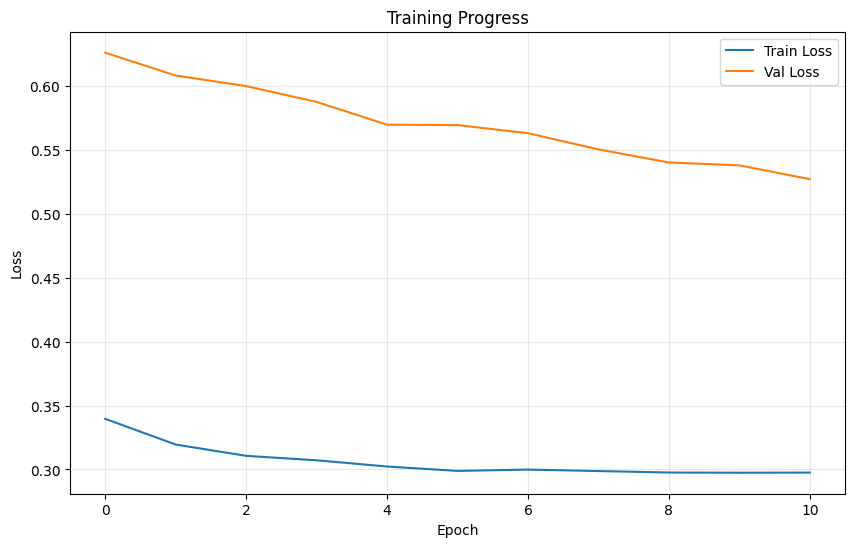

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses_v2, label='Train Loss')
plt.plot(val_losses_v2, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('checkpoints/training_curves.png', dpi=150)
plt.show()